In [96]:
%load_ext autoreload
%autoreload 2
%aimport


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



In [97]:
import numpy as np 
import pickle
import pandas as pd
from tqdm import tqdm

import multicam

import matplotlib.pyplot as plt


In [98]:

metadata_file = "../../data/processed/tng/tng300-1-table.csv"
tng_snapshot_dir = "../../data/processed/tng/TNG300-1/"  # everything is a host halo
tng_dark_snapshot_dir = "../../data/processed/tng/TNG300-1-Dark/"

trees_file = "../../data/processed/tng/TNG300-1_cut_trees.p"
present_snapfile = tng_snapshot_dir + "TNG300-1_HaloHistory_MBP_snap99.hdf5"

dark_trees_file = "../../data/processed/tng/TNG300-1-Dark_cut_trees.p"
present_dark_snapfile = tng_dark_snapshot_dir + "TNG300-1-Dark_HaloHistory_MBP_snap99.hdf5"

color_file = "../../data/processed/tng/Subhalo_StellarPhot_p07c_cf00dust_res_conv_ns1_rad30pkpc_099.hdf5"


## Read and match Hydro/DMO catalogs

In [132]:
from multicam.tng.utils import get_mpeak_from_mah, get_vmax_over_vvir, get_msmhmr, get_color, match_dm_and_hydro_cat, setup_mah_from_trees, match_mah_and_cat, rematch_dm_and_hydro_cat, MISSING, SNAPS


In [133]:
cat = pd.read_hdf(present_snapfile) # hydro
dcat = pd.read_hdf(present_dark_snapfile) # dark matter only

len(cat), len(dcat)


(13643, 13000)

In [134]:
cat, dcat = match_dm_and_hydro_cat(cat, dcat)

len(cat), len(dcat)
sum(cat['dmo_match'] != MISSING), sum(dcat['hydro_match'] != MISSING)


(12695, 12695)

In [135]:
mah_info = setup_mah_from_trees(trees_file, metadata_file, SNAPS)
dmah_info = setup_mah_from_trees(dark_trees_file, metadata_file, SNAPS)


/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:23: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)
/Users/imendoza/code/nbody-relaxed/multicam/tng/utils.py:23: RuntimeWarning: divide by zero encountered in log10
  return np.where(gmass > 0, np.log10(gmass * 1e10 / TNG_H), 0)


In [136]:
mah, dmah = mah_info['mah'], dmah_info['mah']

halo_idx = mah_info['halo_idx']
dhalo_idx = dmah_info['halo_idx']

snaps, zs, scales = mah_info['snaps'], mah_info['z'], mah_info['scales']
dsnaps, dzs, dscales = dmah_info['snaps'], dmah_info['z'], dmah_info['scales']

assert np.all(snaps == dsnaps)
assert np.all(zs == dzs)
assert np.all(scales == dscales)


In [137]:
cat = match_mah_and_cat(halo_idx, cat)
dcat = match_mah_and_cat(dhalo_idx, dcat)

len(cat), len(dcat) 


(3293, 3854)

In [138]:
# finally rematch the hydro and dm catalogs from the columns we created.
cat, dcat, mah, dmah = rematch_dm_and_hydro_cat(cat, dcat, mah, dmah)


  0%|          | 0/3293 [00:00<?, ?it/s]

100%|██████████| 3293/3293 [00:19<00:00, 166.03it/s]


In [139]:
len(cat), len(dcat), mah.shape, dmah.shape


(2467, 2467, (2467, 80), (2467, 80))

In [140]:
m_peak, dm_peak = get_mpeak_from_mah(mah), get_mpeak_from_mah(dmah)


In [141]:
cat['vmax/vvir'] = get_vmax_over_vvir(cat)
dcat['vmax/vvir'] = get_vmax_over_vvir(dcat)


/var/folders/yl/5w7yl6bn1tsc5fjrdtsrsjhh0000gn/T/ipykernel_83214/2924787981.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cat['vmax/vvir'] = get_vmax_over_vvir(cat)


In [142]:
# get defragmented frames
cat = cat.copy()
dcat = dcat.copy()


In [143]:
gmass = mah[:, -1]
dgmass = dmah[:, -1]


In [144]:
msmhmr, _ = get_msmhmr(cat, gmass)
df_color = get_color(color_file, cat)
gr = (df_color['sdss_g'] - df_color['sdss_r']).values

msmhmr.shape, gr.shape


((2467,), (2467,))

In [147]:
# add to hydro catalog for good measure
cat['msmhmr'] = msmhmr
cat['g-r'] = gr


## Cross-Correlations

### Sanity check

/Users/imendoza/Library/Caches/pypoetry/virtualenvs/multicam-P7T5KfjX-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


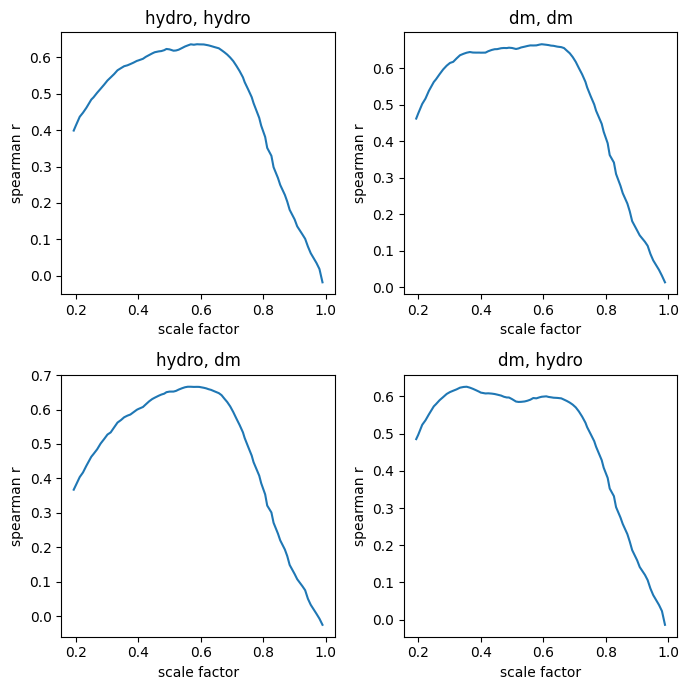

In [145]:
from multicam.correlations import spearmanr
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
axes = axes.flatten()
corrs1 = [] 
corrs2 = []
corrs3 = [] 
corrs4 = []


for ii in range(mah.shape[1]): 
    corrs1.append(spearmanr(cat['cvir'], m_peak[:, ii]))
    corrs2.append(spearmanr(dcat['cvir'], dm_peak[:, ii]))
    corrs3.append(spearmanr(cat['cvir'], dm_peak[:, ii]))
    corrs4.append(spearmanr(dcat['cvir'], m_peak[:, ii]))

corrs = [corrs1, corrs2, corrs3, corrs4]
title = ['hydro, hydro', 'dm, dm', 'hydro, dm', 'dm, hydro']

for ax, corr in zip(axes, corrs):
    ax.plot(scales, corr)
    ax.set_xlabel('scale factor')
    ax.set_ylabel('spearman r')
    ax.set_title(title.pop(0))


plt.tight_layout()


### All DMO properties 

/Users/imendoza/Library/Caches/pypoetry/virtualenvs/multicam-P7T5KfjX-py3.10/lib/python3.10/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


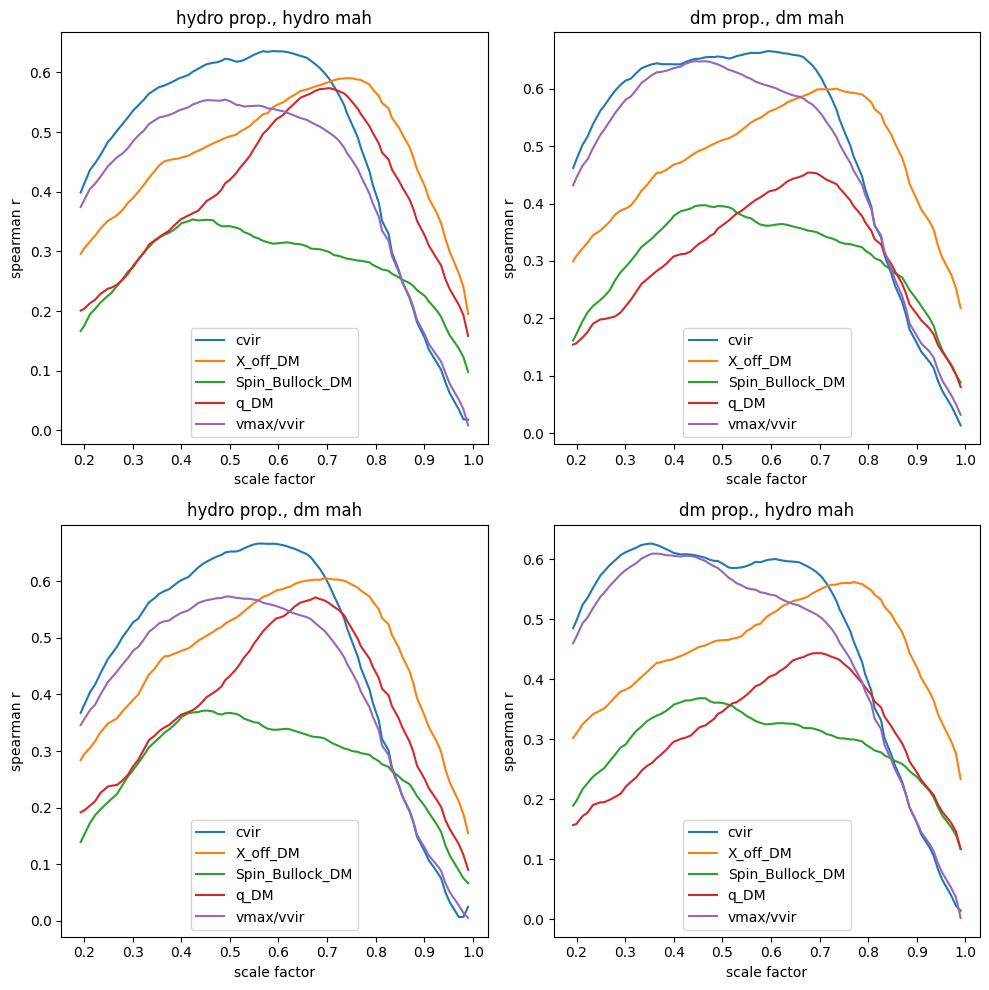

In [164]:
from multicam.correlations import spearmanr

dmo_params = ['cvir', 'X_off_DM', 'Spin_Bullock_DM', 'q_DM', 'vmax/vvir']

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

cat_peak_combs = [(cat, m_peak), (dcat, dm_peak), (cat, dm_peak), (dcat, m_peak)]
titles = ['hydro prop., hydro mah', 'dm prop., dm mah', 'hydro prop., dm mah', 'dm prop., hydro mah']

for ax, (_cat, _peak) in zip(axes, cat_peak_combs):
    for param in dmo_params:
        corrs = [] 
        for ii in range(_peak.shape[1]):
            corrs.append(abs(spearmanr(_cat[param], _peak[:, ii])))
        ax.plot(scales, corrs, label=param)

for ax, title in zip(axes, titles):
    ax.legend()
    ax.set_xlabel('scale factor')
    ax.set_ylabel('spearman r')
    ax.set_title(title)


plt.tight_layout()


### All Hydro properties

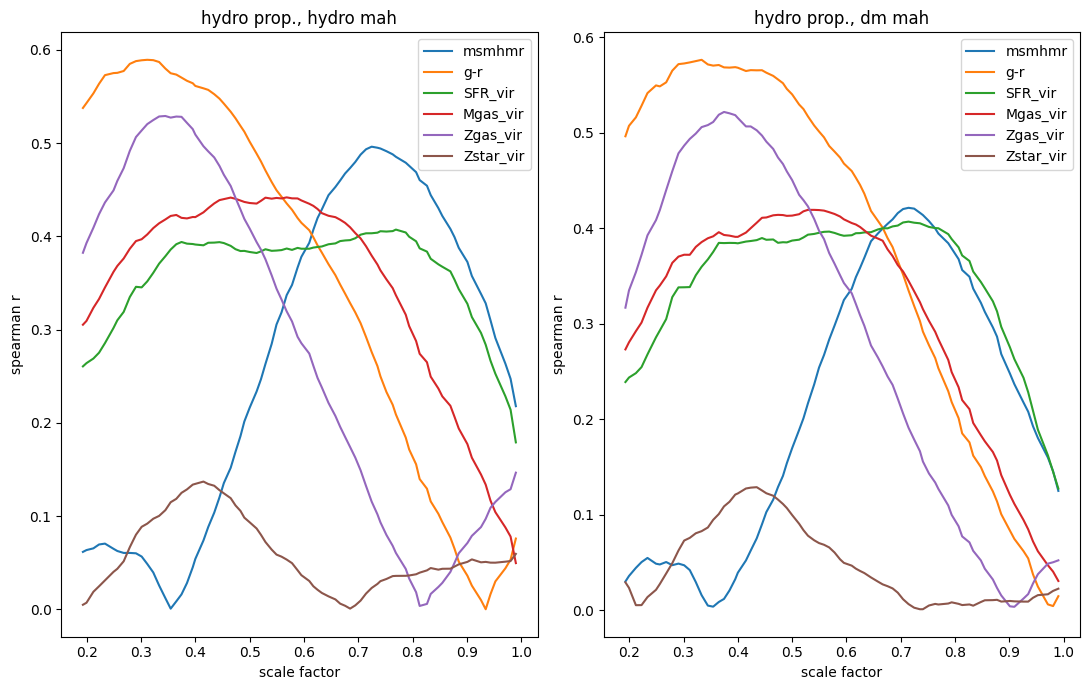

In [165]:
from multicam.correlations import spearmanr

hydro_params = ['msmhmr', 'g-r', 'SFR_vir', 'Mgas_vir', 'Zgas_vir', 'Zstar_vir']

fig, axes = plt.subplots(1, 2, figsize=(11, 7))
axes = axes.flatten()

cat_peak_combs = [(cat, m_peak), (cat, dm_peak)]
titles = ['hydro prop., hydro mah', 'hydro prop., dm mah']

for ax, (_cat, _peak) in zip(axes, cat_peak_combs):
    for param in hydro_params:
        corrs = [] 
        for ii in range(_peak.shape[1]):
            corrs.append(abs(spearmanr(_cat[param], _peak[:, ii])))
        ax.plot(scales, corrs, label=param)

for ax, title in zip(axes, titles):
    ax.legend()
    ax.set_xlabel('scale factor')
    ax.set_ylabel('spearman r')
    ax.set_title(title)


plt.tight_layout()


## MultiCAM rho spearman corrs


In [168]:
cat[dmo_params].values.shape


(2467, 5)

In [170]:
from multicam.models import MultiCAM 

n_features = m_peak.shape[1]
n_targets = len(dmo_params) + len(hydro_params)
all_params = dmo_params + hydro_params


model_hydro = MultiCAM(n_features, n_targets)
model_dmo = MultiCAM(n_features, n_targets)

model_hydro.fit(m_peak, cat[all_params].values)
model_dmo.fit(dm_peak, cat[all_params].values)


In [196]:
# now use all dmo properties (from dmo catalog) to predict hydro
n_features = dm_peak.shape[1] + len(dmo_params)
n_targets = len(dmo_params) + len(hydro_params)
x = np.concatenate([dm_peak, dcat[dmo_params].values], axis=1)
y = cat[all_params].values
model_dmo_all = MultiCAM(n_features, n_targets)

model_dmo_all.fit(x, y)


In [197]:
hydro_pred = model_hydro.predict(m_peak)
dmo_pred = model_dmo.predict(dm_peak)
dmo_all_pred = model_dmo_all.predict(x)


In [202]:
plot_params = ['cvir', 'x0', 'spin_bullock', 'q', 'vmax/vvir', 'msmhmr', 'g-r', 'sfr', 'mgas', 'zgas', 'zstar']
all_params


['cvir',
 'X_off_DM',
 'Spin_Bullock_DM',
 'q_DM',
 'vmax/vvir',
 'msmhmr',
 'g-r',
 'SFR_vir',
 'Mgas_vir',
 'Zgas_vir',
 'Zstar_vir']

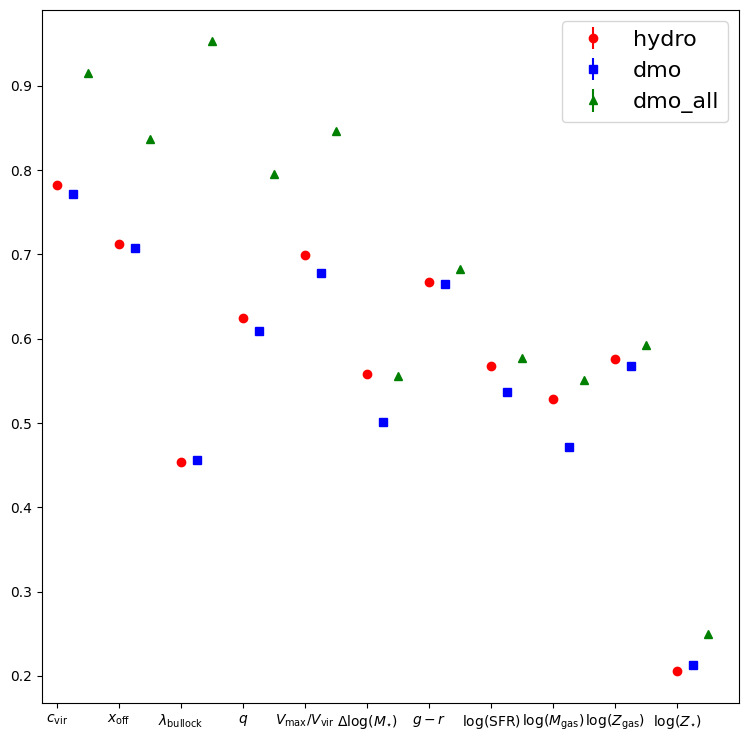

In [201]:
# compare spearman correlation plot of predictions from each model 
# x-axis is label with property predicted, y-axis is spearman r of prediction and truth
from multicam.correlations import spearmanr
from multicam.plotting import metrics_plot

# update rc plots fontsize 
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(1,1, figsize=(9, 9))

# corrs for hydro and dmo
hydro_corrs = []
dmo_corrs = []
dmo_all_corrs = [] 
for ii in range(hydro_pred.shape[1]):
    hydro_corrs.append(spearmanr(cat[all_params].values[:, ii], hydro_pred[:, ii]))
    dmo_corrs.append(spearmanr(cat[all_params].values[:, ii], dmo_pred[:, ii]))
    dmo_all_corrs.append(spearmanr(cat[all_params].values[:, ii], dmo_all_pred[:, ii]))

hydro_corrs = np.array(hydro_corrs)
dmo_corrs = np.array(dmo_corrs)
dmo_all_corrs = np.array(dmo_all_corrs)

metrics_plot(ax, hydro_corrs, np.zeros((11,)), plot_params, 'hydro', x_bias=0.0)
metrics_plot(ax, dmo_corrs, np.zeros((11,)), plot_params, 'dmo', x_bias=0.25, m='s', c='b')
metrics_plot(ax, dmo_all_corrs, np.zeros((11,)), plot_params, 'dmo_all', x_bias=0.5, m='^', c='g')

plt.legend(prop={'size': 16})


## Sandbox

In [47]:
c = pd.DataFrame(columns=['a', 'b'])
c.loc[0] = {'a':1, 'b':2}

c
c.loc[1] = dict(c.loc[0])

c


,a,b
0,1,2
1,1,2


In [46]:
dict(c.iloc[0])


{'a': 1, 'b': 2}

In [54]:
c.iloc[np.array([False, True])]


,a,b
1,1,2


In [58]:
mah.shape


(2467, 80)

In [ ]:
dmo_match_ii = cat["dmo_match"].values[1]
dmo_ids = dcat["dmo_id"].values
is_in = np.isin(dmo_ids, dmo_match_ii)
dict(dcat.iloc[np.where(is_in)[0].item()])
